Загрузка необходимых библиотек и объявление глобальных переменных

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

PATHS = ["/content/drive/MyDrive/Dataset_gas_types/Bensol/",
         "/content/drive/MyDrive/Dataset_gas_types/Toluol/",
         #"/content/drive/MyDrive/Dataset_gas_types/H2S/",
         #"/content/drive/MyDrive/Dataset_gas_types/O-Ksilol_v1/"
        ]

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


Подключение гугл диска для импорта данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузка значений параметров из файлов с исходными данными в виде списка массивов numpy.

In [ ]:
data = []
gt = []
# Find all .txt files in current directory
for PATH in PATHS:
    for filepath in glob.glob(PATH + '*.txt'):
        with open(filepath, 'r') as file:                # Open files
            lines = file.readlines()[1:]                 # Skip first line
            cleaned_data = []
            for line in lines:
                cleaned_line = line.replace(',', '.')    # Change decimal separators
                if len(cleaned_line.split()) != 10:      # Check shape of loaded data
                    print("Warning! Invalid number of parameters. File: ", filepath)
                new_line = list(map(float, cleaned_line.split()))
                cleaned_data.append(new_line)            # Append parsed line to list of data
                gt.append(PATH.rstrip('/').rsplit('/', 2)[-1]) # Get labeles for imported data
            data.append(np.array(cleaned_data))

print("Imported dataset length = ", len(data))

Imported dataset length =  36


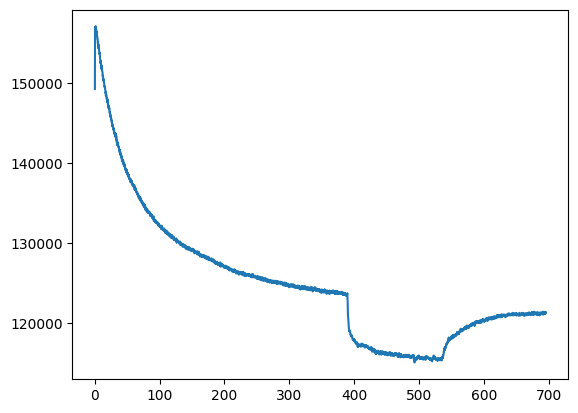

In [ ]:
#plt.plot(data[0][:, 0], data[0][:, 1])
#plt.plot(data[10][:, 0], data[10][:, 2])
plt.plot(data[10][:, 0], data[10][:, 6]) # Visualise imported data
#plt.plot(data[10][:, 0], data[10][:, 4])

Convert imported data to DataFrame structure using pandas lib.

In [ ]:
#columns = ["V_h", "P", "R_h", "T", "V_m", "R_m", "dR/dT", "Triangle", "Iter", "Gas Type"]
rows = []
k = 0

for file in data:
  for row in range(25, file.shape[0], 25):
    v_h = file[row-25:row, 1].mean()
    p = file[row-25:row, 2].mean()
    r_h = file[row-25:row, 3].mean()
    t = file[row-25:row, 4].mean()
    v_m = file[row-25:row, 5].mean()
    r_m = file[row-25:row, 6].mean()
    dr_dt = file[row-25:row, 7].mean()
    tr = file[row-25:row, 8].mean()
    it = file[row-25:row, 9].mean()
    gas_type = gt[k]
    k += 25
    new_data = {"V_h": v_h, "P": p, "R_h": r_h, "T": t, "V_m": v_m, "R_m": r_m, "dR/dT": dr_dt, "Triangle": tr, "Iter": it, "Gas Type": gas_type}
    rows.append(new_data)

df_data = pd.DataFrame(rows)

# print((df_data['Gas Type'] == "H2S").sum())
# print("Total dataset shape: ", df_data.shape)
# indexes = df_data.index[df_data['Gas Type'] == "H2S"].to_numpy()

# msk1 = np.random.rand(len(indexes)) < 0.8
# indexes_to_del = indexes[msk1]
# df_data = df_data.drop(indexes_to_del)
# print((df_data['Gas Type'] == "H2S").sum())

print("Total dataset shape: ", df_data.shape)
df_data[:5]

Total dataset shape:  (3727, 10)


,V_h,P,R_h,T,V_m,R_m,dR/dT,Triangle,Iter,Gas Type
0,3.539844,0.024944,502.341182,154.026314,7.436060,297555.1236,-3535.219560,295420.2720,-623.24,Bensol
1,3.539287,0.024957,501.928926,153.363342,7.494658,306630.5212,-3652.793340,304654.3252,-623.28,Bensol
2,3.539093,0.024962,501.771883,153.110792,7.521848,311117.9496,-3722.063704,309080.8132,-623.40,Bensol
3,3.538885,0.024965,501.654895,152.922657,7.543197,314710.8504,-3773.482740,312555.5384,-623.28,Bensol
4,3.538905,0.024961,501.730000,153.043435,7.559057,317421.1488,-3805.046956,315429.9652,-623.28,Bensol


Set architecture of FCNN and initialize model.

In [ ]:
class GasTypeClass(nn.Module):
    def __init__(self, input_size, output_size, layer_size_list):
        super(GasTypeClass, self).__init__()

        self.in_layer = nn.Linear(input_size, layer_size_list[0])
        self.bn = nn.BatchNorm1d(layer_size_list[0])
        self.act1 = nn.ReLU()
        self.layers = nn.ModuleList()
        self.act2 = nn.ReLU()
        for n in range(1, len(layer_size_list)):
            self.layers.append(nn.Linear(layer_size_list[n-1], layer_size_list[n]))
            if n % 4 == 0:
                self.layers.append(nn.Dropout(0.5))
            elif n % 2 == 0:
                self.layers.append(nn.BatchNorm1d(layer_size_list[n]))
        self.out_layer = nn.Linear(layer_size_list[-1], output_size)

    def forward(self, x):
        x = self.act1(self.bn(self.in_layer(x)))
        for l_num, l in enumerate(self.layers):
            if l_num == 1 or l_num == 7 or l_num == 5:
                x = l(x)
            else:
                x = self.act2(l(x))
        x = self.out_layer(x)
        return x

# Instantiate the model
input_size = 9                                         # We have nine features
output_size = 4                                        # We have 4 classes
layer_size_list = [64, 128, 256, 512, 256, 128, 64]    # Hidden layers sizes

# Initialize the model
model = GasTypeClass(input_size, output_size, layer_size_list).to(device)
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                       # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)    # Optimization algorythm

GasTypeClass(
  (in_layer): Linear(in_features=9, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (act2): ReLU()
  (out_layer): Linear(in_features=64, out_features=4, bias=True)
)


Prepare data for training loop.

In [ ]:
msk = np.random.rand(len(df_data)) < 0.8   #mask for train-test split

# Prepare parameters data
params = Normalizer().fit_transform(df_data[["V_h", "P", "R_h", "T", "V_m", "R_m", "dR/dT", "Triangle", "Iter"]].values)   # Normalize data
params_train = params[msk]
params_test = params[~msk]
params_tensor_train = torch.FloatTensor(params_train).to(device)    # Converting to tensors
params_tensor_test = torch.FloatTensor(params_test).to(device)
print(params_tensor_train[:5])                                      # Show first five lines

# Prepare gas type labeles
gt_encoder = preprocessing.LabelEncoder()
gt_encoder.fit(["Bensol", "Toluol", "H2S", "O-Ksilol_v1"])              # Encode labeles from strings to integers
class_vals = gt_encoder.transform(np.array([["Bensol"], ["Toluol"], ["H2S"], ["O-Ksilol_v1"]]))
print(f"Encoded gas type values: \nBensol = {class_vals[0]} \nToluol = {class_vals[1]} \nH2S = {class_vals[2]} \nO-Ksilol_v1 = {class_vals[3]}")  # Print Encoded values
gt_vec = gt_encoder.transform(df_data[["Gas Type"]].values.reshape(-1))
gt_train = gt_vec[msk]
gt_test = gt_vec[~msk]
gt_tensor_train = torch.tensor(gt_train, dtype=torch.long).to(device)  # Converting to tensor
gt_tensor_test = torch.tensor(gt_test, dtype=torch.long).to(device)
print("\n", gt_tensor_train[-5:])

tensor([[ 8.4420e-06,  5.9488e-08,  1.1980e-03,  3.6733e-04,  1.7734e-05,
          7.0962e-01, -8.4309e-03,  7.0453e-01, -1.4863e-03],
        [ 8.1878e-06,  5.7735e-08,  1.1612e-03,  3.5479e-04,  1.7338e-05,
          7.0936e-01, -8.4504e-03,  7.0479e-01, -1.4419e-03],
        [ 7.9783e-06,  5.6282e-08,  1.1310e-03,  3.4476e-04,  1.7006e-05,
          7.0951e-01, -8.5072e-03,  7.0465e-01, -1.4052e-03],
        [ 7.9079e-06,  5.5778e-08,  1.1212e-03,  3.4199e-04,  1.6891e-05,
          7.0930e-01, -8.5027e-03,  7.0485e-01, -1.3928e-03],
        [ 7.8504e-06,  5.5392e-08,  1.1126e-03,  3.3879e-04,  1.6801e-05,
          7.0964e-01, -8.5523e-03,  7.0451e-01, -1.3823e-03]], device='cuda:0')
Encoded gas type values: 
Bensol = 0 
Toluol = 3 
H2S = 1 
O-Ksilol_v1 = 2

 tensor([3, 3, 3, 3, 3], device='cuda:0')


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# Prepare training set
train_dataset = TensorDataset(params_tensor_train, gt_tensor_train)

# Prepare the test set
test_dataset = TensorDataset(params_tensor_test, gt_tensor_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Training loop for Model

In [ ]:
# Training parameters
num_epochs = 1000

# Lists to store metrics for plotting
losses = []
accuracies = []

# Training loop
for epoch in range(num_epochs):

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (param, gas_type) in enumerate(train_loader):
        param, gas_type = param.to(device), gas_type.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        pred = model(param)
        loss = criterion(pred, gas_type)

        # Backward pass
        loss.backward()

        # Optimization step
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(pred.data, 1)
        total += gas_type.size(0)
        correct += (predicted == gas_type).sum().item()

        if (i + 1) % 47 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)


print('Training complete!')

Epoch [1/1000], Step [47/47], Loss: 0.7313, Accuracy: 47.89%
Epoch [2/1000], Step [47/47], Loss: 0.6171, Accuracy: 62.45%
Epoch [3/1000], Step [47/47], Loss: 0.6103, Accuracy: 65.16%
Epoch [4/1000], Step [47/47], Loss: 0.5812, Accuracy: 67.07%
Epoch [5/1000], Step [47/47], Loss: 0.6238, Accuracy: 68.04%
Epoch [6/1000], Step [47/47], Loss: 0.5222, Accuracy: 68.64%
Epoch [7/1000], Step [47/47], Loss: 0.5323, Accuracy: 68.14%
Epoch [8/1000], Step [47/47], Loss: 0.5917, Accuracy: 69.81%
Epoch [9/1000], Step [47/47], Loss: 0.5768, Accuracy: 70.38%
Epoch [10/1000], Step [47/47], Loss: 0.4569, Accuracy: 69.95%
Epoch [11/1000], Step [47/47], Loss: 0.5557, Accuracy: 70.62%
Epoch [12/1000], Step [47/47], Loss: 0.6316, Accuracy: 69.88%
Epoch [13/1000], Step [47/47], Loss: 0.4440, Accuracy: 70.82%
Epoch [14/1000], Step [47/47], Loss: 0.5223, Accuracy: 70.45%
Epoch [15/1000], Step [47/47], Loss: 0.4898, Accuracy: 69.91%
Epoch [16/1000], Step [47/47], Loss: 0.5519, Accuracy: 70.62%
Epoch [17/1000], 

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for gts, labels in test_loader:
            gts, labels = gts.to(device), labels.to(device)
            outputs = model(gts)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return all_preds, all_targets, accuracy

Test Accuracy: 68.20%


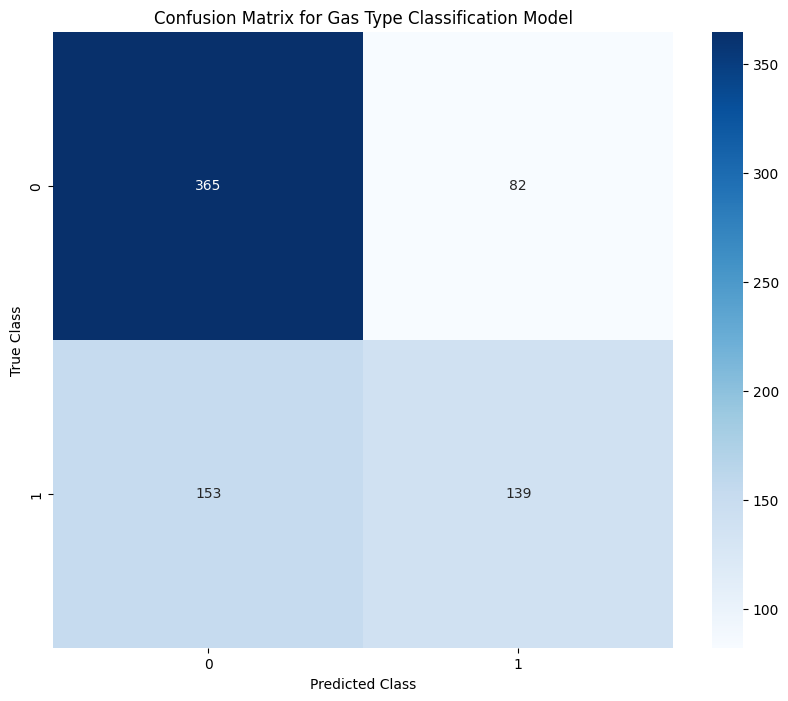

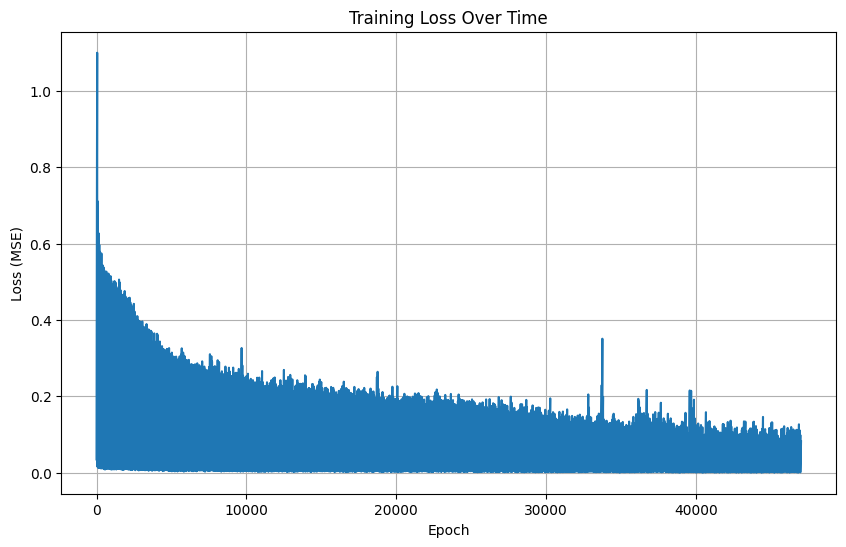

In [ ]:
# Evaluate model
gt_preds, gt_targets, gt_accuracy = evaluate_model(model, test_loader)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(gt_targets, gt_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Gas Type Classification Model')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save